# LLM 사용해보기

### ✨ 실습 개요 <br>

1) 실습 목적 <br>
- 이번 실습에서는 현재 사용 가능한 LLM 에 대해 직접 활용해봅니다. <br>
- 이미 pre-training/fine-tuning 된 공개 모델의 ckpt 를 불러와 다양한 task를 수행해보고 (huggingface pipeline), chat-gpt web 과 API 사용 방법에 대해 알아봅니다.   <br>


 2) 수강 목표
  - 이미 학습되어 있는 모델의 ckpt 를 가져와 사용할 수 있다.
  - chatgpt web 버전을 사용할 수 있다.
  - chatgpt API를 호출하여 사용할 수 있다.

### 실습 목차

1. 공개된 모델 checkpoint 활용하기
  * 1-1. checkpoint 직접 load
  * 1-2. pipeline 활용하기
2. chat-gpt 활용하기
  * 2-1. web
  * 2-2. API

### ⚙️ 데이터 및 환경설정
- 베이스라인에 필요한 라이브러리들을 설치합니다.
- 런타임 유형을 GPU로 설정합니다.

###### 환경설정



```
torch
pandas
numpy
transformers
sklearn
openai
```
- 코랩에서는 transformers,openai 만 설치


In [ ]:
!pip install transformers==4.18.0
!pip install transformers[torch]
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 26.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 48.4 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=24ed19c59ef5b9fc47ef937d46a15e415b86cc7f2e670ac409d2ff6bffd598f3
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.8 MB/s eta 0:00:00


- "런타임" > "런타임유형변경" > "Python3, T4 GPU" 선택

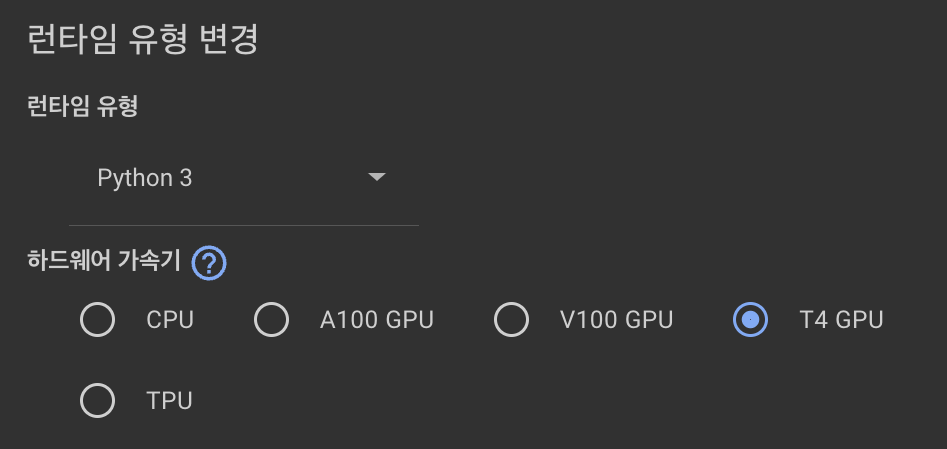

In [ ]:
import torch
torch.cuda.is_available() # GPU 할당여부 확인

False

### 1️⃣ 1. 공개된 모델 checkpoint 활용하기

```
💡 목차 개요 : 이미 pre-training/fine-tuning 된 공개 모델의 checkpoint 를 불러와 다양한 task를 수행해봅니다.
```

- 1-1 checkpoint 직접 load
- 1-2 Huggingface pipeline 활용하기


#### 1-1 checkpoint 직접 load

> transformers 패키지에 이미 선언되어 있는 Class 를 활용하여 모델의 checkpoint 를 load 해봅니다



In [ ]:
# transformers 패키지에 이미 선언되어 있는 Class 를 활용하여 모델의 checkpoint 를 load > GPT2 model
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

tokenizer = GPT2Tokenizer.from_pretrained("gpt2") # tokenizer load
model = GPT2LMHeadModel.from_pretrained("gpt2") #model checkpoint load

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
# 실제 입력을 통해 잘 tokenizing 되는지 확인
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt") # 원하는 입력을 tokenizing
print(inputs) # input_ids, attention_masks

{'input_ids': tensor([[15496,    11,   616,  3290,   318, 13779]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [ ]:
# 모델에 tokenized input 을 넣은 후 generate 를 통해 생성된 결과를 확인
greedy_output = model.generate(**inputs, max_new_tokens=40)
print(greedy_output) # 실제 문장을 보려면 decode 필요

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[15496,    11,   616,  3290,   318, 13779,    13,   314,  1101,   407,
          1654,   611,   673,   338,   257, 26188,   393,   407,    13,   314,
          1101,   407,  1654,   611,   673,   338,   257,  3290,   393,   407,
            13,   314,  1101,   407,  1654,   611,   673,   338,   257,  3290,
           393,   407,    13,   198,   198,    40]])


In [ ]:
# decoding 하면 생성된 문장을 확인 가능
tokenizer.decode(greedy_output[0])

"Hello, my dog is cute. I'm not sure if she's a puppy or not. I'm not sure if she's a dog or not. I'm not sure if she's a dog or not.\n\nI"

In [ ]:
# model 에 특화된 class 를 써도 되지만, 자동으로 load 할 수 있는 AutoTokenizer, AutoModel 사용 가능
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
checkpoint = "gpt2"
model = AutoModelForCausalLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
# 여러 개 sentences 로 구성 가능
sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]

encoded = tokenizer.encode(sequences, return_tensors="pt")

In [ ]:
import torch
with torch.no_grad():
    generated_ids = model.generate(
        encoded,
        do_sample=False,
        min_length=10,
        max_length=50,
    )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
print(tokenizer.decode([el.item() for el in generated_ids[0]]))


I've been waiting for a HuggingFace course my whole life.This course is amazing! I've been waiting for a HuggingFace course my whole life.This course is amazing!

I've been waiting for a HuggingFace course


#### 1-2 Huggingface pipeline 활용하기

> Huggingface 패키지의 pipeline 를 활용하여 모델의 ckpt 를 더 간단히 load 해봅니다



In [ ]:
# pipeline 으로 더 짧고, 쉽게 task 수행 가능
# text 생성 task
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
# max_length : 생성할 문장의 최대 길이
# num_return_sequences : 몇 개의 후보 문장을 생성할 것인지 지정
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

### 2️⃣ chat-gpt 활용하기

```
💡 목차 개요 : chat-gpt 를 활용해봅니다.
```

- 2-1 web에서 직접 사용하기
- 2-2 API 로 후출하여 사용하기


#### 2-1 web 에서 직접 사용하기

> https://chat.openai.com/ 에 접속/로그인 후 아래 입력창에 prompt 를 입력


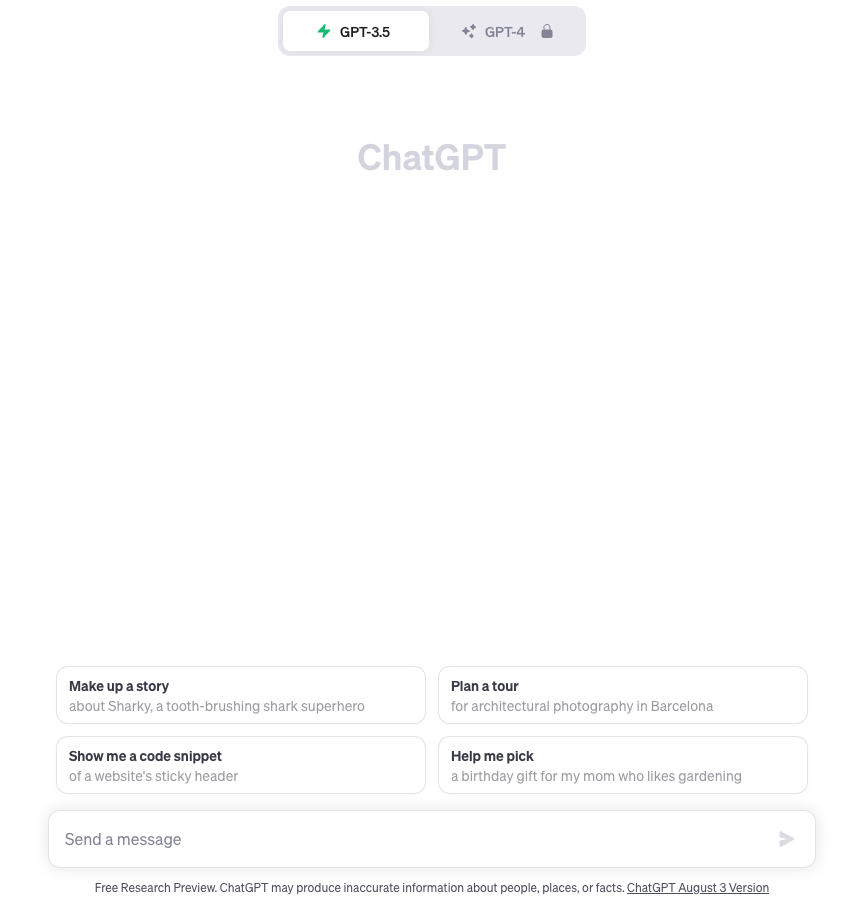


#### 2-2 API로 호출하여 사용하기

> 요금 정책 : https://openai.com/pricing
> 사용 가이드 : https://platform.openai.com/docs/introduction



1) https://platform.openai.com/overview 가입 후 token 생성하기
가입시 등록 필요 정보
- 이름, 생년월일
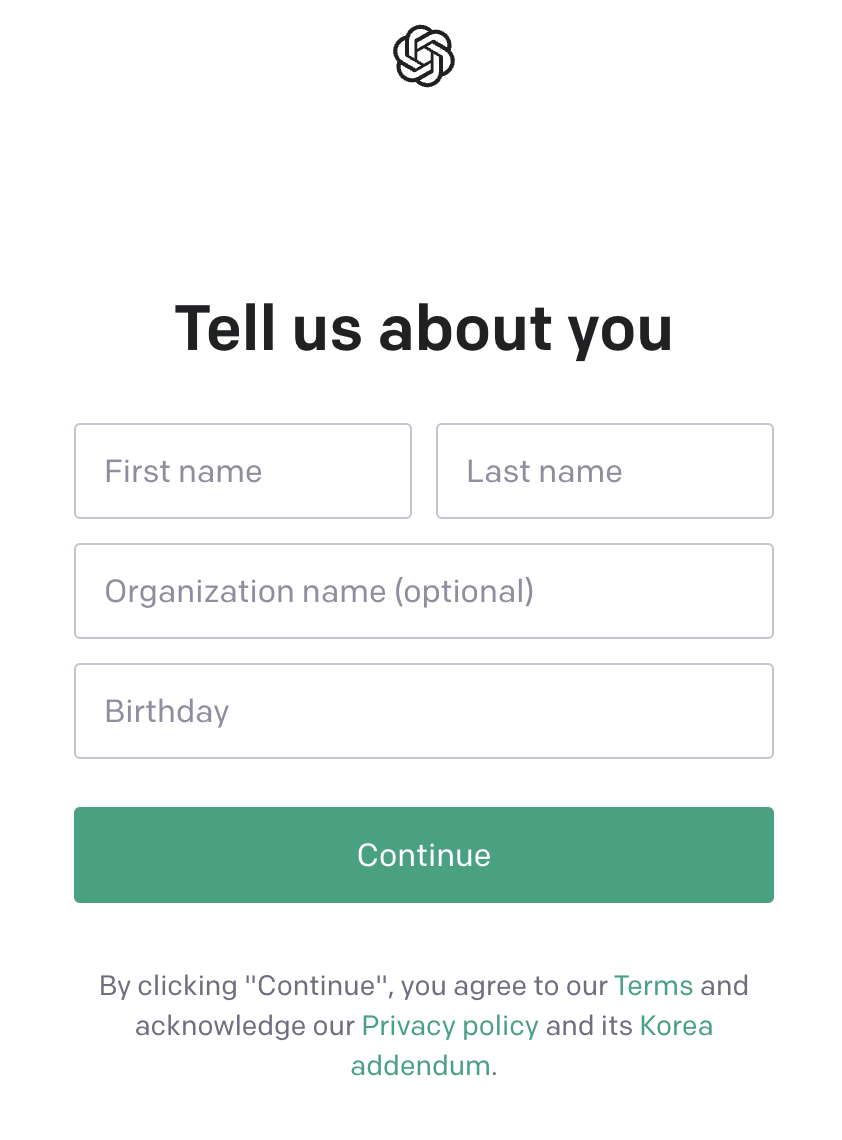
- 휴대폰 번호 인증
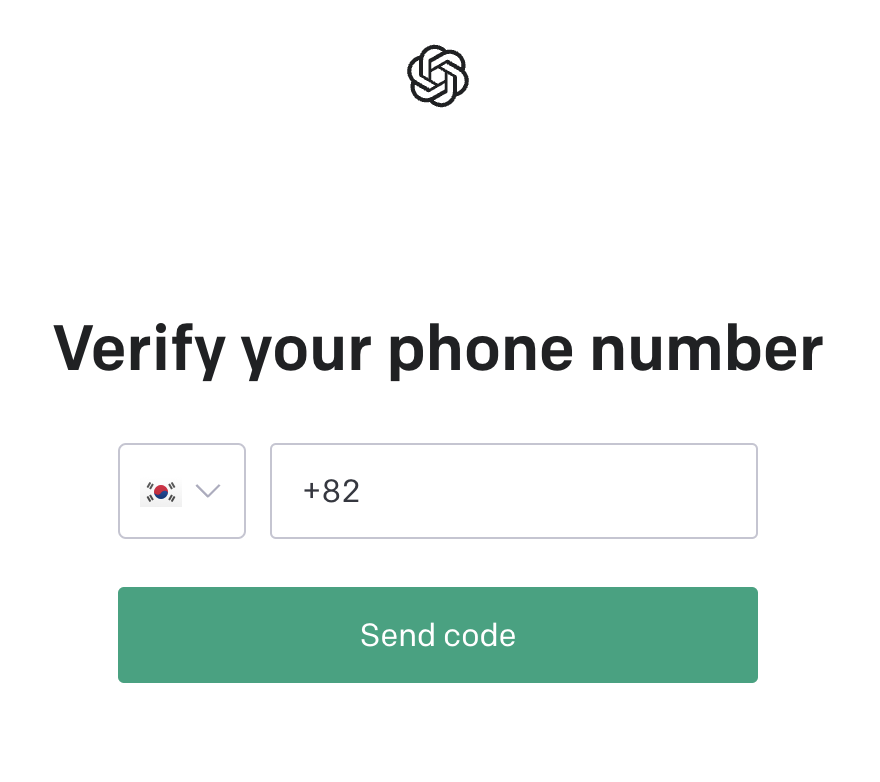

1.   우측 상단 "Personal" 클릭
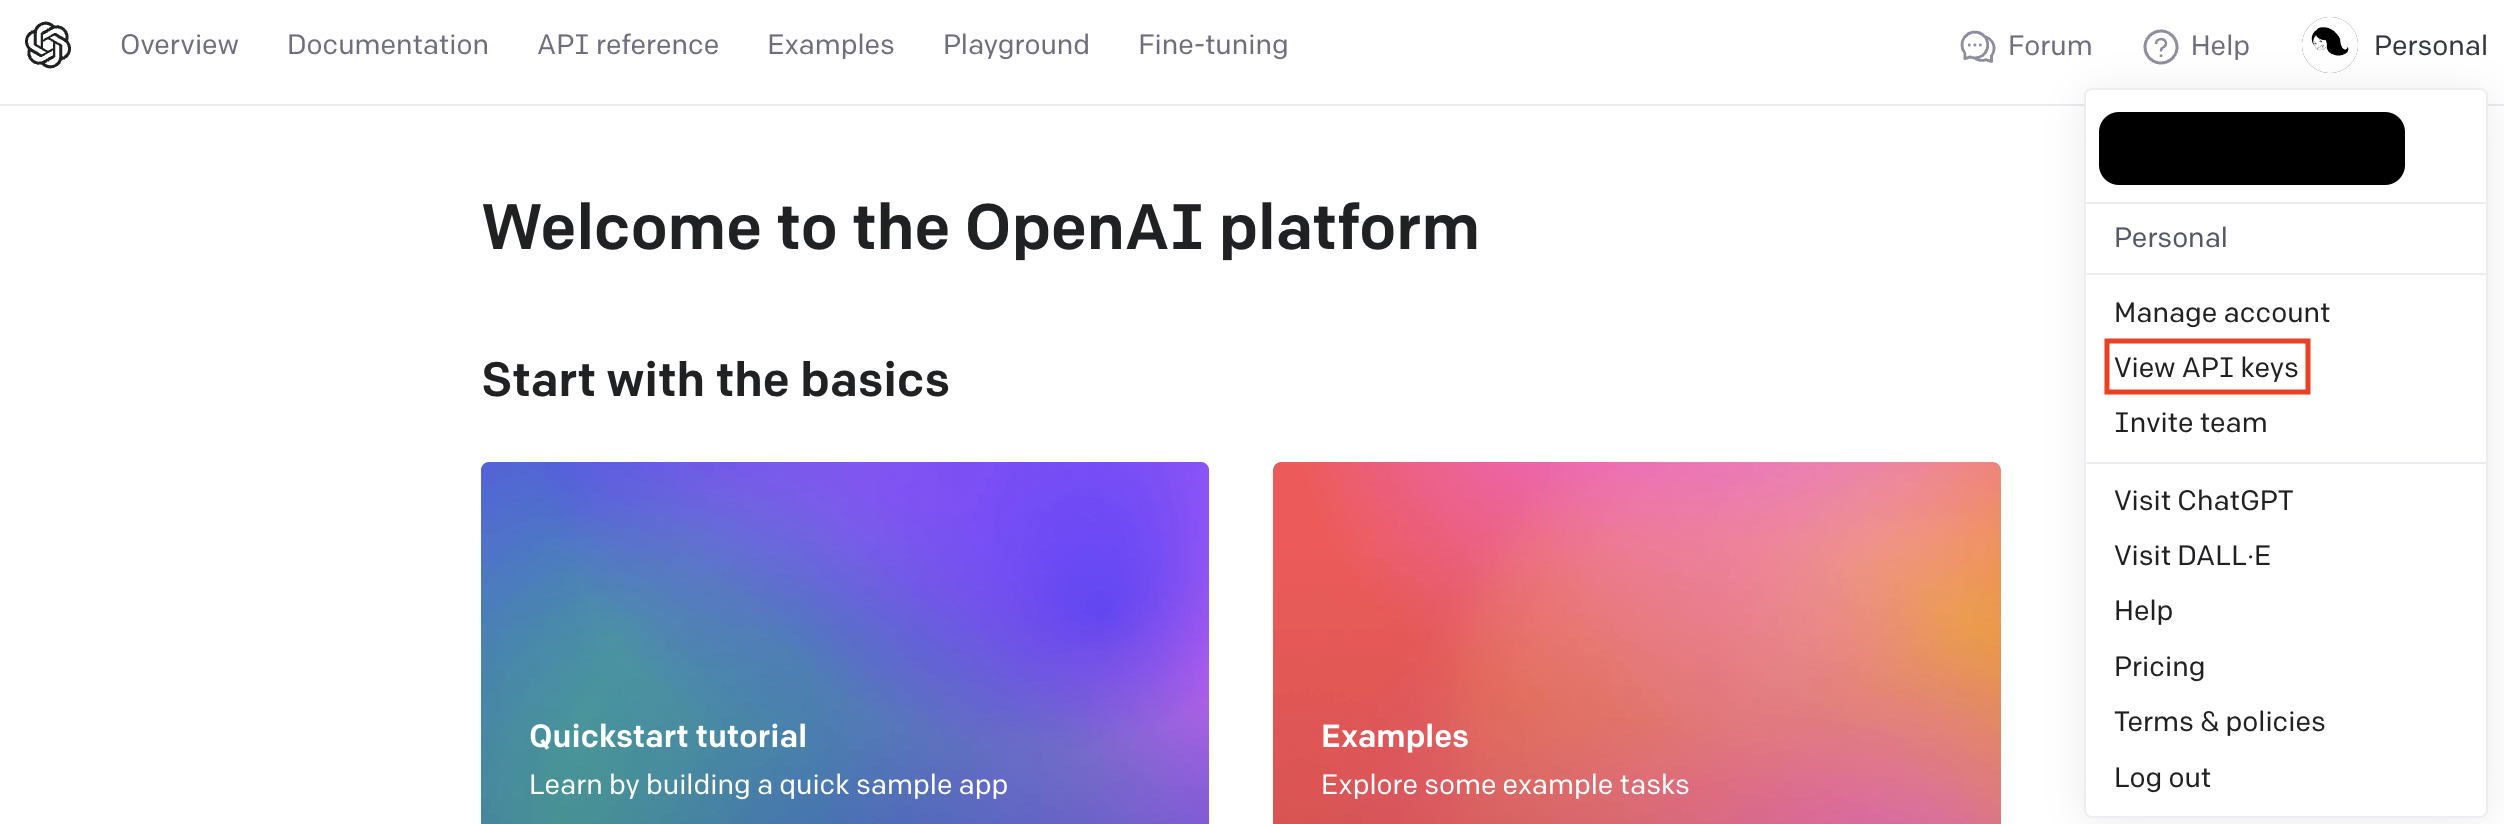
2.   개인 API keys 발급
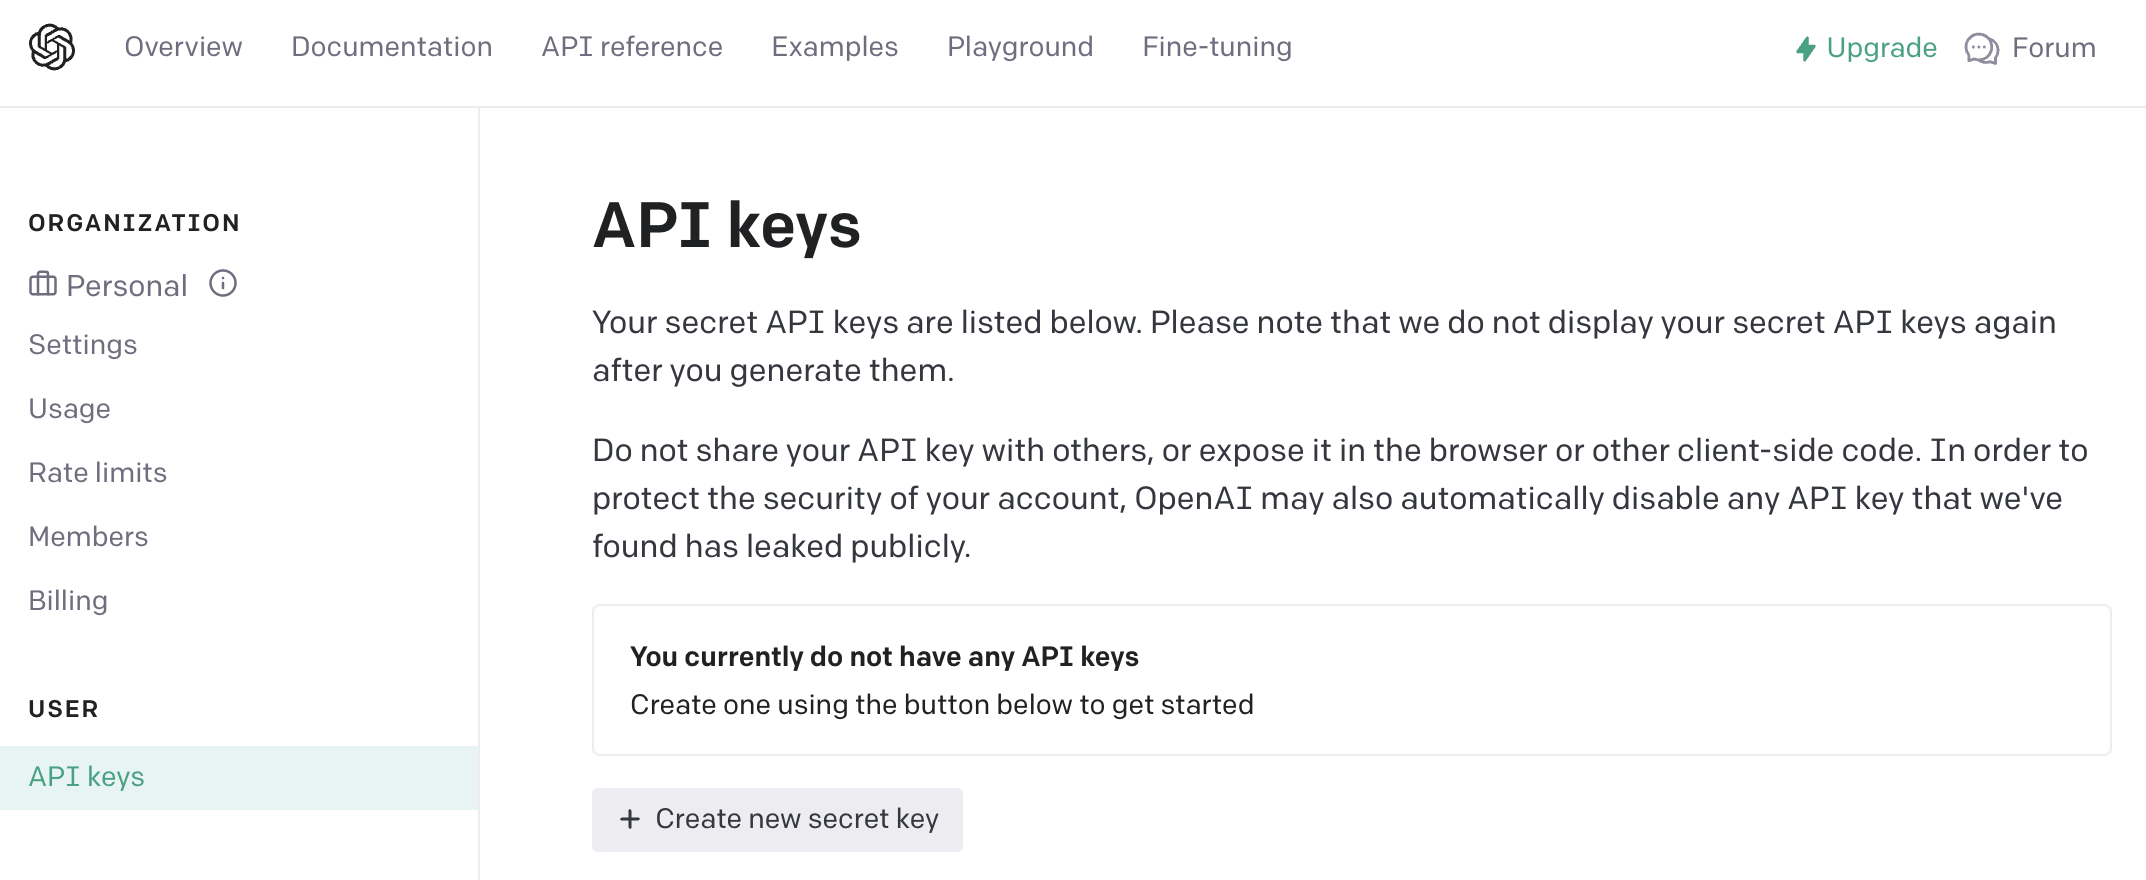

3. key 발급하기
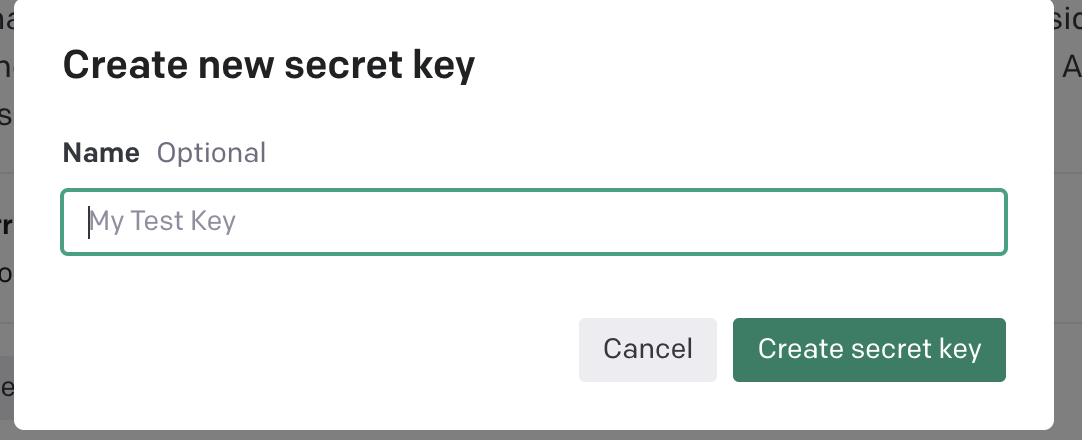
4. key copy & save (처음 1회만 전체 확인 가능, 이후엔 재발급)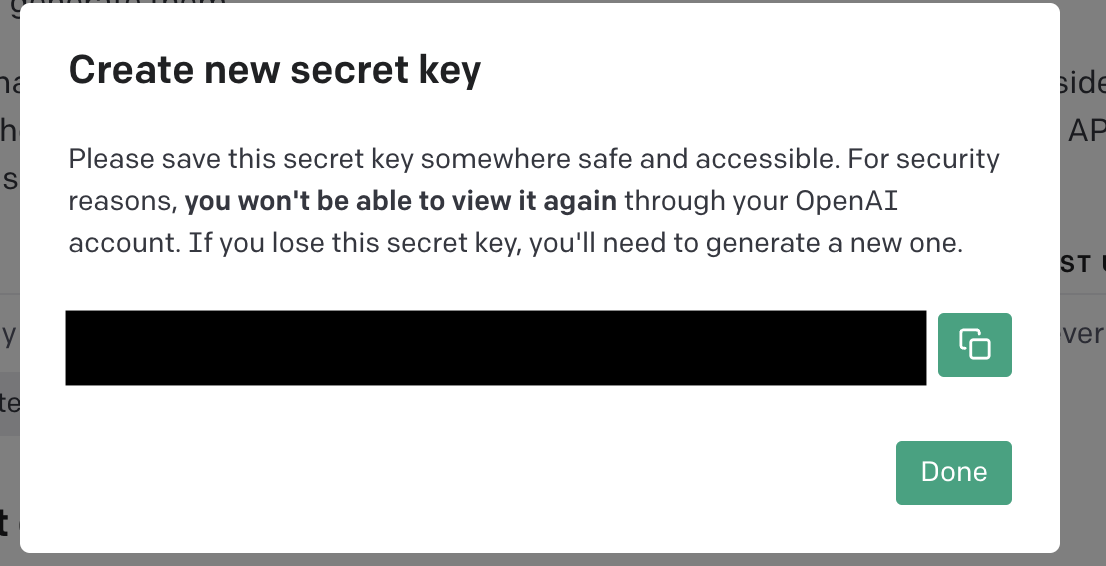

5. 생성 완료
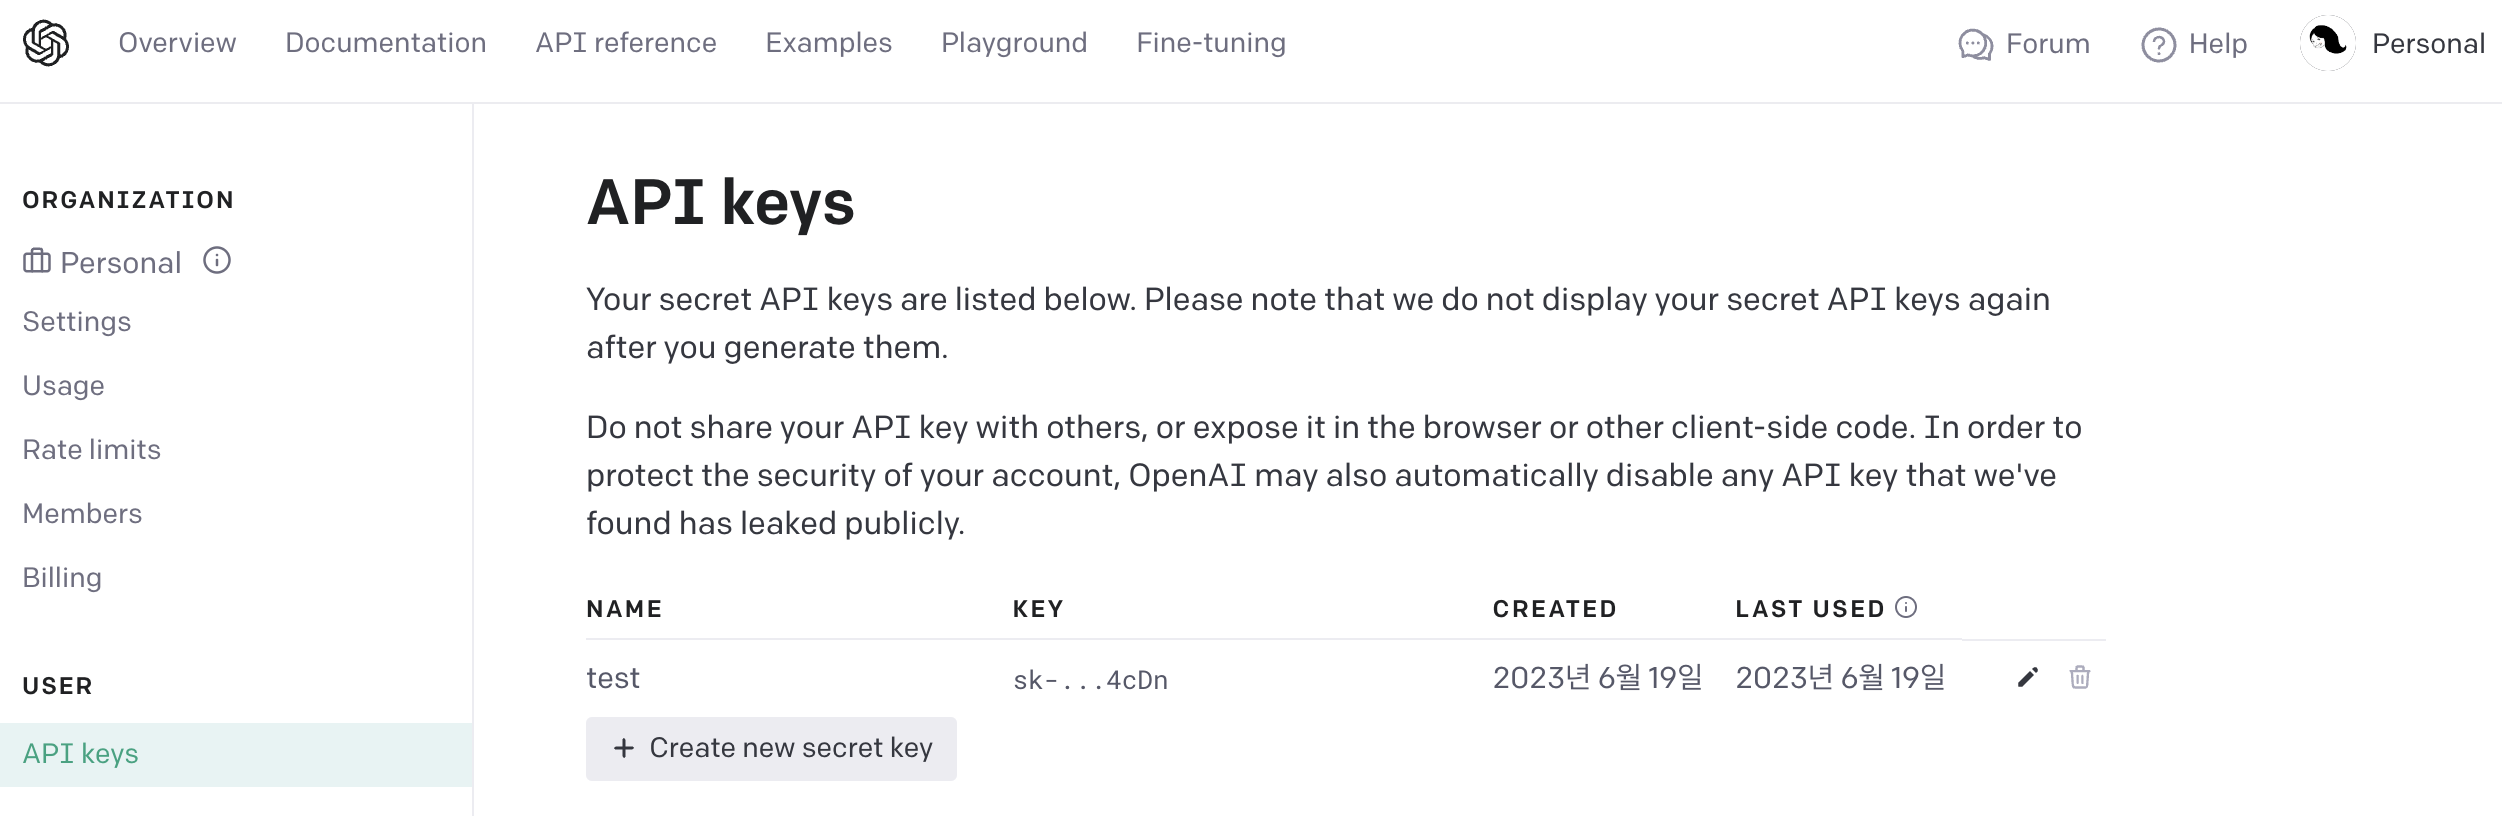

In [ ]:
# API 로 호출
import openai

openai.api_key = "개인 API Key를 입력해주세요"
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model='gpt-3.5-turbo', #['gpt-3.5-turbo', 'gpt-4'	,'davinci-002' : GPT3 ]
        messages=messages,
        temperature=0, # 모델의 결과물이 실행할 때 마다 달라지는 정도
    )
    return response.choices[0].message["content"]

prompt = "원하는 글을 입력해주세요"
get_completion(prompt)

#Reference

- [ref 1](https://platform.openai.com/docs/introduction) : openai 사용 방법 가이드

## Required Package

<font color=gray>
 <br>
transformers==4.18.1 <br>
openai == 0.28.0 <br>
</font>




## 콘텐츠 라이선스

저작권 : <font color='blue'> <b> ©2023 by Upstage X fastcampus Co., Ltd. All rights reserved.</font></b>

<font color='red'><b>WARNING</font> : 본 교육 콘텐츠의 지식재산권은 업스테이지 및 패스트캠퍼스에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다. </b>